In [407]:
import json
import datetime
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("whitegrid")
matplotlib.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 18
    })

## Load Data

In [119]:
df_raw_meetings = pd.read_json('data/members.json')
df_raw_cosponsors = pd.read_json('data/cosponsors.json')
df_raw_votes = pd.read_json('data/votes.json')

In [254]:
df_raw_votes = df_raw_votes.rename(columns={'bill_id': 'bill_name', 'id': 'member_name'})

### Member View

- member_id
- member_name
- subclub (0, 1, 2: unknown)

In [318]:
members_exploded = df_raw_meetings.explode('members')
members_exploded = members_exploded.rename(columns={'members': 'member_name'})
members_exploded = members_exploded[['member_name', 'subclub']]
df_members = members_exploded.reset_index(drop=True)

df_members = df_members.drop_duplicates()
num_members_before = len(df_members)
df_members = df_members.drop_duplicates(subset=['member_name'])
num_members_after = len(df_members)
print(f'There are {num_members_before - num_members_after} members participating in multiple clubs.')

There are 75 members participating in multiple clubs.


In [319]:
df_members = df_members.merge(df_raw_votes[['member_name']].drop_duplicates(), on='member_name', how='outer')
df_members['subclub'] = df_members['subclub'].fillna(2)
df_members = df_members.sort_values(by=['member_name', 'subclub']).reset_index(drop=True).reset_index().rename(columns={'index': 'member_id'})

In [320]:
df_members.head(3)

,member_id,member_name,subclub
0,0,A000014,0.0
1,1,A000022,0.0
2,2,A000031,1.0


### Bill View

- bill_id
- bill_name
- bill_type
- actions_date (date)
- member_name
- num_actions
- num_sponsors
- is_sponsor (bool)
- is_cosponsor (bool)


df_bills_with_sponsor

- bill_id
- bill_name
- bill_type
- actions_date (date)
- member_id
- member_name
- num_actions
- num_sponsors
- is_sponsor (bool)
- is_cosponsor (bool)

In [334]:
df_raw_cosponsors['num_actions'] = df_raw_cosponsors['actions_dates'].apply(lambda x: len(x))
df_raw_cosponsors['num_sponsors'] = df_raw_cosponsors['cosponsors'].apply(lambda x: len(x)) + 1

In [335]:
bills_exploded = df_raw_cosponsors.explode('actions_dates')
bills_exploded = bills_exploded.rename(columns={'actions_dates': 'actions_date', 'bill_id': 'bill_name'})
df_bills_list_cosponsors = bills_exploded[['bill_name', 'bill_type', 'actions_date', 'cosponsors', 'sponsor', 'num_actions', 'num_sponsors']]
df_bills_list_cosponsors = df_bills_list_cosponsors.drop_duplicates(subset=['bill_name', 'bill_type', 'actions_date', 'sponsor', 'num_actions', 'num_sponsors'])
df_bills_list_cosponsors['actions_date'] = df_bills_list_cosponsors['actions_date'].map(lambda x: str(x)[:10])
df_bills_list_cosponsors['actions_date'] = pd.to_datetime(df_bills_list_cosponsors['actions_date'])

In [336]:
df_bills_exploding_cosponsors = df_bills_list_cosponsors.explode('cosponsors')
df_bills_exploding_cosponsors = df_bills_exploding_cosponsors.rename(columns={'cosponsors': 'cosponsor'})

In [328]:
df_bills_sponsor = df_bills_exploding_cosponsors[['bill_name', 'bill_type', 'actions_date', 'sponsor', 'num_actions', 'num_sponsors']]
df_bills_cosponsor = df_bills_exploding_cosponsors[['bill_name', 'bill_type', 'actions_date', 'cosponsor', 'num_actions', 'num_sponsors']]
df_bills_sponsor = df_bills_sponsor.rename(columns={'sponsor': 'member_name'})
df_bills_cosponsor = df_bills_cosponsor.rename(columns={'cosponsor': 'member_name'})
df_bills_sponsor['is_sponsor'] = 1
df_bills_cosponsor['is_sponsor'] = 0
df_bills_cosponsor['is_cosponsor'] = 1
df_bills_sponsor['is_cosponsor'] = 0
df_bills_with_sponsor_and_actions = pd.concat([df_bills_sponsor, df_bills_cosponsor])
df_bills_with_sponsor_and_actions = df_bills_with_sponsor_and_actions.dropna(subset=['member_name', 'actions_date']).reset_index(drop=True)

In [355]:
df_bills = df_bills_with_sponsor_and_actions[df_bills_with_sponsor_and_actions['is_sponsor'] == 1].drop(columns=['is_sponsor', 'is_cosponsor'])
df_bills = df_bills.sort_values(by=['bill_name', 'actions_date']).drop_duplicates(subset=['bill_name'], keep='first')
df_bills = df_bills.rename(columns={'actions_date': 'first_actions_date'})
df_bills = df_bills.merge(df_raw_votes[['bill_name', 'bill_type']].drop_duplicates(), on=['bill_name', 'bill_type'], how='outer')
df_bills['bill_type_id'] = df_bills['bill_type'].astype('category').cat.codes
df_bills = df_bills.sort_values(by=['bill_name', 'first_actions_date']).reset_index(drop=True).reset_index().rename(columns={'index': 'bill_id'})
df_bills['bill_id'] = df_bills['bill_id'] + len(df_members)

In [356]:
df_bills.head(3)

,bill_id,bill_name,bill_type,first_actions_date,member_name,num_actions,num_sponsors,bill_type_id
0,1966,a1-103,a,1993-01-05,C000634,2.0,1.0,0
1,1967,a1-105,a,1997-01-07,C000556,4.0,1.0,0
2,1968,a1-106,a,1999-01-06,A000217,6.0,1.0,0


In [298]:
# df_bills['bill_id'] = df_bills.reset_index(drop=True) + len(df_members)

In [348]:
df_bills_with_sponsor = df_bills_with_sponsor_and_actions[['bill_name', 'bill_type', 'actions_date', 'member_name', 'is_sponsor', 'is_cosponsor', 'num_actions', 'num_sponsors']]
df_bills_with_sponsor = df_bills_with_sponsor_and_actions.sort_values(by=['bill_name', 'member_name', 'actions_date']).drop_duplicates(subset=['bill_name', 'member_name'], keep='first')

df_bills_with_sponsor = df_bills_with_sponsor.merge(df_members[['member_name', 'member_id']], on='member_name', how='left')
df_bills_with_sponsor = df_bills_with_sponsor.merge(df_bills[['bill_name', 'bill_id', 'bill_type_id']], on='bill_name', how='left')

In [349]:
df_bills_with_sponsor

,bill_name,bill_type,actions_date,member_name,num_actions,num_sponsors,is_sponsor,is_cosponsor,member_id,bill_id,bill_type_id
0,a1-103,a,1993-01-05,C000634,2,1,1,0,250,0,0
1,a1-105,a,1997-01-07,C000556,4,1,1,0,243,1,0
2,a1-106,a,1999-01-06,A000217,6,1,1,0,16,2,0
3,a1-107,a,2001-01-03,A000217,6,1,1,0,16,3,0
4,a1-108,a,2003-01-07,D000492,6,1,1,0,406,4,0
...,...,...,...,...,...,...,...,...,...,...,...
116751,h99-113,h,2013-04-16,T000464,2,7,1,0,1834,68645,7
116752,h99-114,h,2015-03-10,C000174,6,4,0,1,224,68646,7
116753,h99-114,h,2015-03-10,C001088,6,4,0,1,330,68646,7
116754,h99-114,h,2015-03-10,N000032,6,4,1,0,1136,68646,7


### Vote View


bill_name	bill_type	date	member_name	group	district	vote	result	bill_id	member_id

- date
- bill_id
- bill_name
- bill_type
- member_id
- member_name
- group
- district
- vote (Y, N, NA)
- result (N:0, Y: 1, NA: 2)

In [360]:
df_votes = df_raw_votes
df_votes['date'] = pd.to_datetime(df_votes['date'])
df_votes['result'] = df_votes['vote'].map({'NV': 2, 'Y': 1, 'N': 0})

In [361]:
# merge to add bill_id and member_id
df_votes = df_votes.merge(df_bills[['bill_name', 'bill_id']], on='bill_name', how='left')
df_votes = df_votes.merge(df_members[['member_name', 'member_id']], on='member_name', how='left')

In [362]:
df_votes.head(3)

,bill_name,bill_type,date,member_name,group,district,vote,result,bill_id,member_id
0,c5-104,c,1995-01-31 16:48:00-05:00,M000687,1,0,NV,2,25615,1026
1,c925-104,c,1995-03-02 18:27:00-05:00,B000028,1,1,NV,2,35088,46
2,c925-104,c,1995-03-02 18:27:00-05:00,B000918,1,2,NV,2,35088,106


## Basic Analysis

### Member

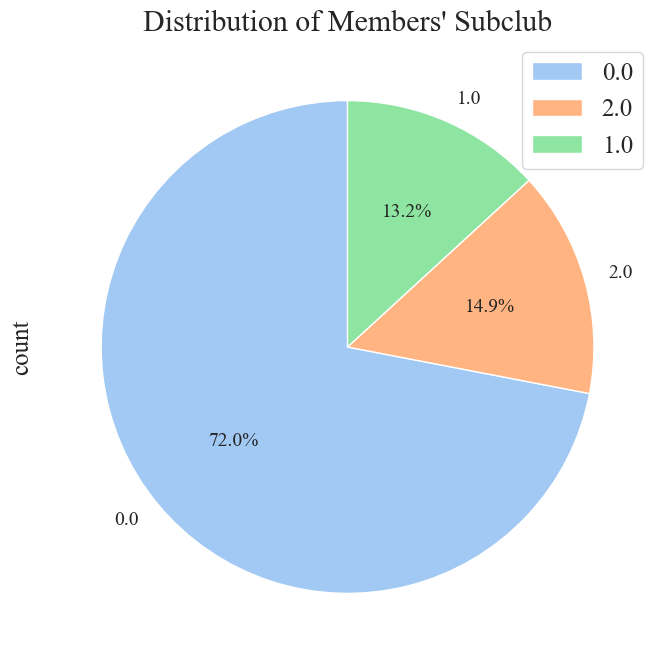

In [365]:
# plot a pie chart of the distribution of members' subclub

plt.figure(figsize=(8, 8))
palette = sns.color_palette('pastel')
df_members['subclub'].value_counts().plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%', startangle=90, fontsize=14, colors=palette)
plt.title('Distribution of Members\' Subclub')
plt.legend()

### Bill

In [366]:
df_bills.head(3)

,bill_id,bill_name,bill_type,first_actions_date,member_name,num_actions,num_sponsors,bill_type_id
0,1966,a1-103,a,1993-01-05,C000634,2.0,1.0,0
1,1967,a1-105,a,1997-01-07,C000556,4.0,1.0,0
2,1968,a1-106,a,1999-01-06,A000217,6.0,1.0,0


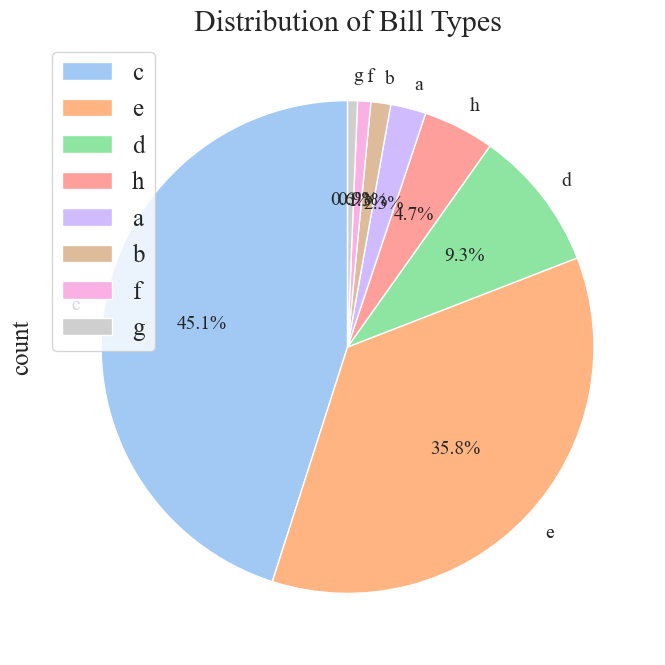

In [367]:
# plot a distribution of the bill types

plt.figure(figsize=(8, 8))
palette = sns.color_palette('pastel')
df_bills['bill_type'].value_counts().plot(kind='pie', figsize=(8, 8), autopct='%1.1f%%', startangle=90, fontsize=14, colors=palette)
plt.title('Distribution of Bill Types')
plt.legend()


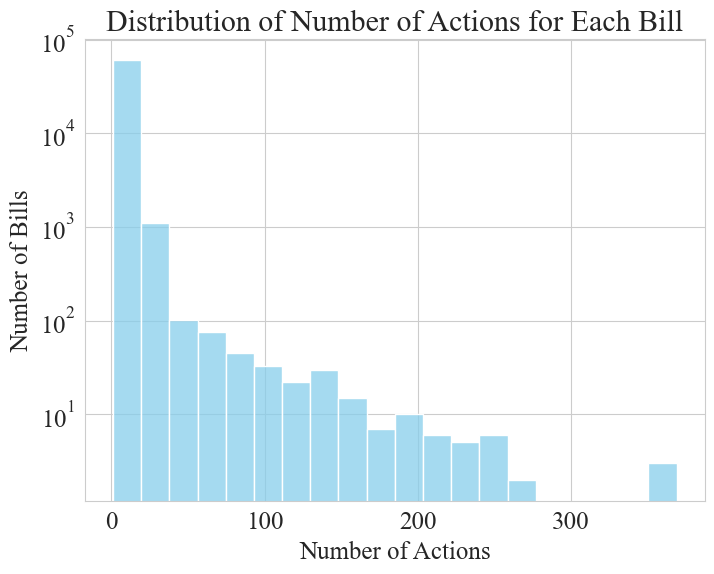

In [375]:
# plot a histogram of the number of actions for each bill

plt.figure(figsize=(8, 6))
sns.histplot(data=df_bills, x='num_actions', bins=20, color='skyblue', log_scale=[False, True])
plt.title('Distribution of Number of Actions for Each Bill')
plt.xlabel('Number of Actions')
plt.ylabel('Number of Bills')
plt.show()

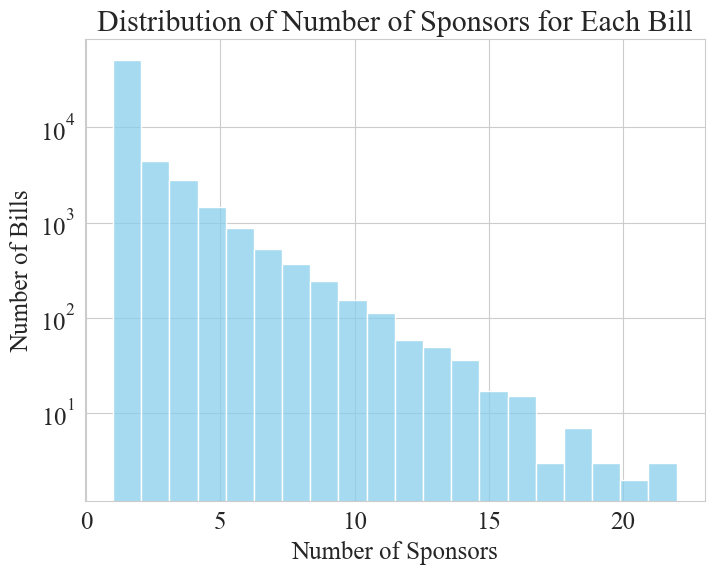

In [378]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_bills, x='num_sponsors', bins=20, color='skyblue', log_scale=[False, True])
plt.title('Distribution of Number of Sponsors for Each Bill')
plt.xlabel('Number of Sponsors')
plt.ylabel('Number of Bills')
plt.show()

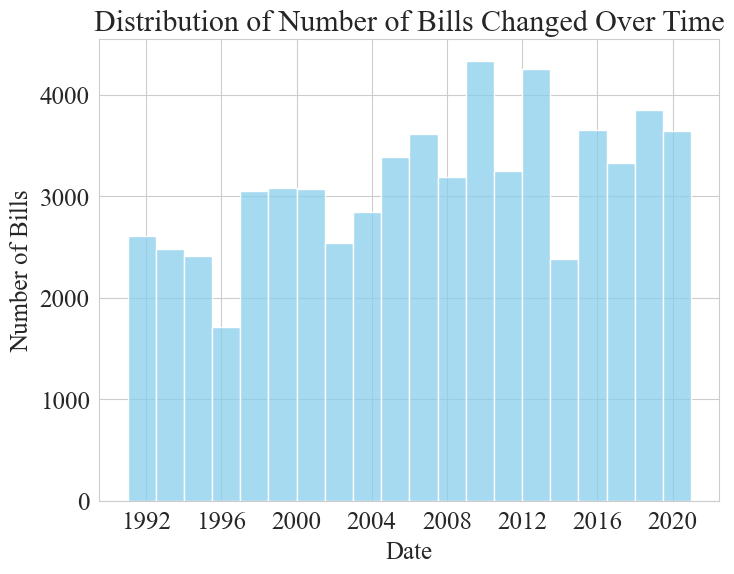

In [380]:
# plot the number of bills changed over time

plt.figure(figsize=(8, 6))
sns.histplot(data=df_bills, x='first_actions_date', bins=20, color='skyblue')
plt.title('Distribution of Number of Bills Changed Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Bills')
plt.show()

### Vote

In [381]:
df_votes.head(3)

,bill_name,bill_type,date,member_name,group,district,vote,result,bill_id,member_id
0,c5-104,c,1995-01-31 16:48:00-05:00,M000687,1,0,NV,2,25615,1026
1,c925-104,c,1995-03-02 18:27:00-05:00,B000028,1,1,NV,2,35088,46
2,c925-104,c,1995-03-02 18:27:00-05:00,B000918,1,2,NV,2,35088,106


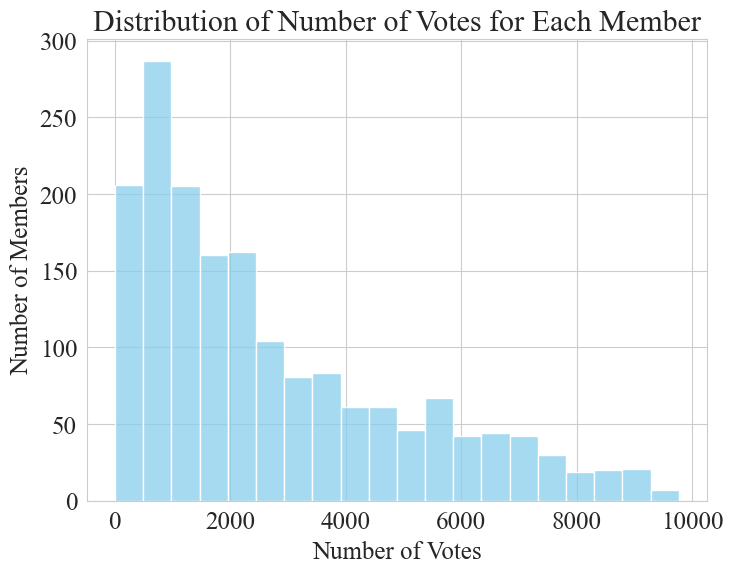

In [382]:
# plot the distribution of the number of votes for each member

df_votes_member = df_votes.groupby('member_id').agg({'result': 'count'}).reset_index().rename(columns={'result': 'num_votes'})
plt.figure(figsize=(8, 6))
sns.histplot(data=df_votes_member, x='num_votes', bins=20, color='skyblue')
plt.title('Distribution of Number of Votes for Each Member')
plt.xlabel('Number of Votes')
plt.ylabel('Number of Members')
plt.show()

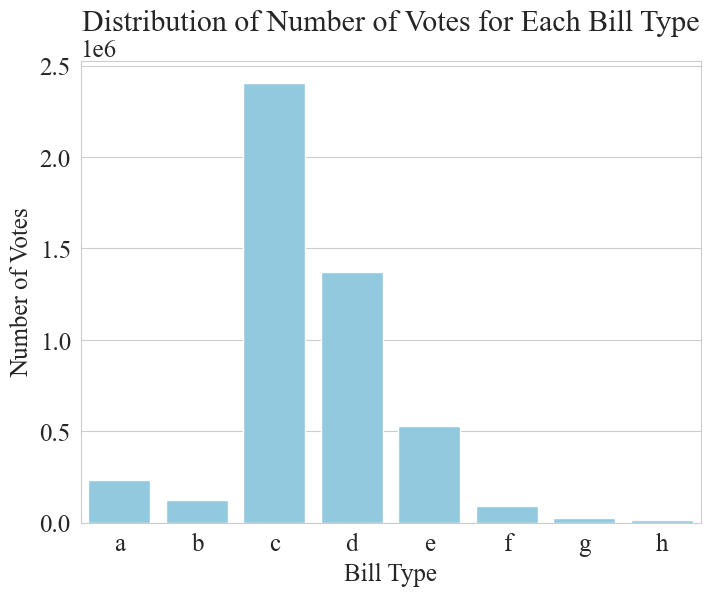

In [383]:
# plot the distribution of the number of votes for each bill type

df_votes_bill = df_votes.groupby('bill_type').agg({'result': 'count'}).reset_index().rename(columns={'result': 'num_votes'})
plt.figure(figsize=(8, 6))
sns.barplot(data=df_votes_bill, x='bill_type', y='num_votes', color='skyblue')
plt.title('Distribution of Number of Votes for Each Bill Type')
plt.xlabel('Bill Type')
plt.ylabel('Number of Votes')
plt.show()

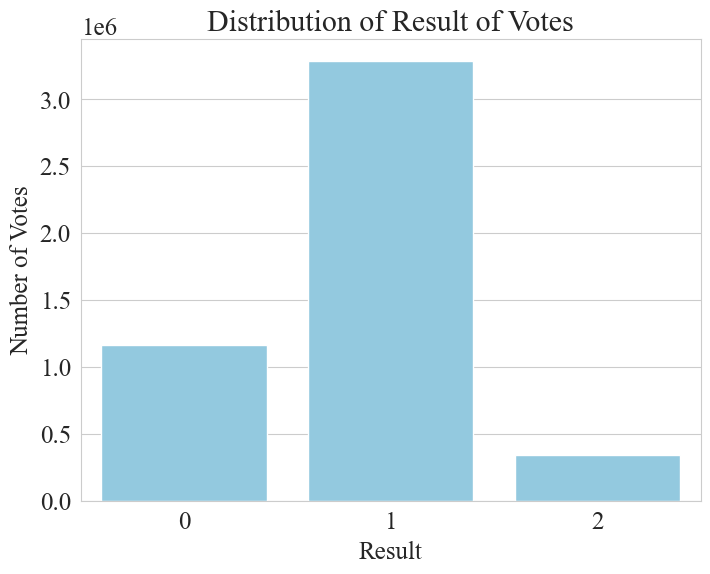

In [385]:
# plot the distribution of the result of votes

df_votes_result = df_votes.groupby('result').agg({'member_id': 'count'}).reset_index().rename(columns={'member_id': 'num_votes'})
plt.figure(figsize=(8, 6))
sns.barplot(data=df_votes_result, x='result', y='num_votes', color='skyblue')
plt.title('Distribution of Result of Votes')
plt.xlabel('Result')
plt.ylabel('Number of Votes')
plt.show()


<Figure size 800x600 with 0 Axes>

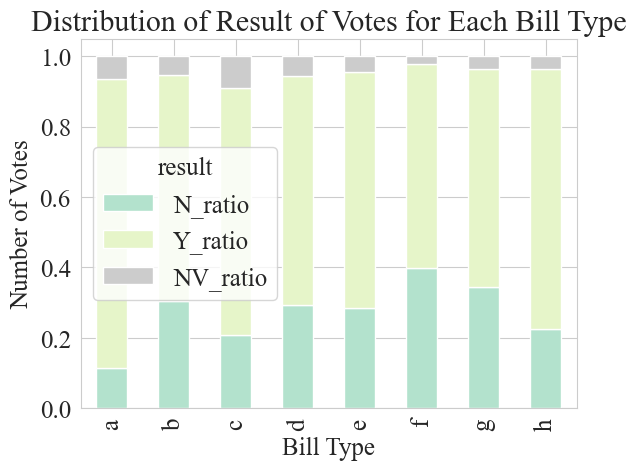

In [387]:
# plot the distribution of the result of votes of each bill type using stacked bar chart (Number of bars = number of bill types)

df_votes_result_bill = df_votes.groupby(['bill_type', 'result']).agg({'member_id': 'count'}).reset_index().rename(columns={'member_id': 'num_votes'})
df_votes_result_bill_num_votes = df_votes_result_bill.pivot(index='bill_type', columns='result', values='num_votes').reset_index()
df_votes_result_bill_num_votes = df_votes_result_bill_num_votes.reset_index(drop=True)

# normalize the number of votes for each bill type
df_votes_result_bill_num_votes['total_votes'] = df_votes_result_bill_num_votes[[0, 1, 2]].sum(axis=1)
df_votes_result_bill_num_votes['N_ratio'] = df_votes_result_bill_num_votes[0] / df_votes_result_bill_num_votes['total_votes']
df_votes_result_bill_num_votes['Y_ratio'] = df_votes_result_bill_num_votes[1] / df_votes_result_bill_num_votes['total_votes']
df_votes_result_bill_num_votes['NV_ratio'] = df_votes_result_bill_num_votes[2] / df_votes_result_bill_num_votes['total_votes']

plt.figure(figsize=(8, 6))


df_votes_result_bill_num_votes_for_plot = df_votes_result_bill_num_votes[['bill_type', 'N_ratio', 'Y_ratio', 'NV_ratio']]
df_votes_result_bill_num_votes_for_plot.plot(x='bill_type', kind='bar', stacked=True, colormap='Pastel2',
                                             title='Distribution of Result of Votes for Each Bill Type')
plt.xlabel('Bill Type')
plt.ylabel('Number of Votes')
plt.show()

## Graph Construction

In [690]:
G = nx.MultiDiGraph()

### Node

In [691]:
# add member nodes to the graph, while adding the subclub attribute to each node
for i, member_info in df_members.iterrows():
    member_id = member_info['member_id']
    attrs = {'subclub': member_info['subclub'], 'name': member_info['member_name'], 'type_name': 'member'}
    G.add_node(member_id, **attrs, type=0)

# add bill nodes to the graph, while adding the bill type attribute to each node
for i, bill_info in df_bills.iterrows():
    bill_id = bill_info['bill_id']
    attrs = {
        'bill_type': bill_info['bill_type'], 
        'bill_type_id': bill_info['bill_type_id'], 
        'first_actions_date': bill_info['first_actions_date'],
        'num_actions': bill_info['num_actions'],
        'num_sponsors': bill_info['num_sponsors'],
        'name': bill_info['bill_name'], 
        'type_name': 'bill'}
    G.add_node(bill_id, **attrs, type=1)

### Edge

In [692]:
UNKNOWN_GROUP = df_votes['group'].max() + 1
UNKNOWN_DISTRICT = df_votes['district'].max() + 1

In [693]:
# add edges between members and bills from the votes
for i, vote_info in df_votes.iterrows():
    member_id = vote_info['member_id']
    bill_id = vote_info['bill_id']
    result = vote_info['result']
    group = vote_info['group']
    district = vote_info['district']
    G.add_edge(member_id, bill_id, result=result, group=group, district=district)

# add edges between members and bills from the sponsors
for i, sponsor_info in df_bills_with_sponsor.iterrows():
    member_id = sponsor_info['member_id']
    bill_id = sponsor_info['bill_id']
    G.add_edge(member_id, bill_id, result=1, group=UNKNOWN_GROUP, district=UNKNOWN_DISTRICT)
    

In [694]:
NUM_MEMBERS_NODES = len([n for n in G.nodes if G.nodes[n]['type'] == 0])
NUM_BILLS_NODES = len([n for n in G.nodes if G.nodes[n]['type'] == 1])
NUM_NODES = G.number_of_nodes()
NUM_EDGES = G.number_of_edges()


G.graph['num_members_nodes'] = NUM_MEMBERS_NODES
G.graph['num_bills_nodes'] = NUM_BILLS_NODES
G.graph['num_nodes'] = NUM_NODES
G.graph['num_edges'] = NUM_EDGES

### Save Dataset

In [696]:
nx.write_gpickle(G, 'data/graph.gpickle')

### Temporal Graph

In [697]:
# filter the graph with nx.subgraph that the action date of the bill is after 2019-01-01 and before 2020-01-01 based on subgraph

def filter_graph_by_date(G, start_date, end_date, verbose=False):
    if isinstance(start_date, str):
        start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    if isinstance(end_date, str):
        end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    G_sub_nodes = [n for n, d in G.nodes(data=True) if d['type_name'] == 'bill' and d['first_actions_date'] >= start_date and d['first_actions_date'] < end_date]
    G_sub_member_nodes = [n for n, d in G.nodes(data=True) if d['type_name'] == 'member']
    G_sub_nodes += G_sub_member_nodes
    G_sub = G.subgraph(G_sub_nodes)
    # filter the members who have no edges
    G_sub_nodes = [n for n, d in G_sub.nodes(data=True) if G_sub.degree(n) > 0]
    G_sub = G_sub.subgraph(G_sub_nodes)
    G_sub_member_nodes = [n for n, d in G_sub.nodes(data=True) if d['type_name'] == 'member']
    G_sub_bill_nodes = [n for n, d in G_sub.nodes(data=True) if d['type_name'] == 'bill']
    print(f'Sub_G (num_nodes={G_sub.number_of_nodes()}, num_edges={G_sub.number_of_edges()}, start_date={start_date}, end_date={end_date})') if verbose else None
    print(f'Number of member nodes: {len(G_sub_member_nodes)}, number of bill nodes: {len(G_sub_bill_nodes)}, number of edges: {G_sub.number_of_edges()}') if verbose else None
    return G_sub

In [609]:
start_date = '2019-01-01'
end_date = '2020-01-01'

G_sub = filter_graph_by_date(G, start_date, end_date, verbose=True)

Sub_G (num_nodes=4604, num_edges=60619, start_date=2019-01-01 00:00:00, end_date=2020-01-01 00:00:00)
Number of member nodes: 1786, number of bill nodes: 2818, number of edges: 60619


## PyG Dataset

In [698]:
import torch
from torch_geometric.data import HeteroData, Data

In [699]:
G = nx.read_gpickle('data/graph.gpickle')
start_date = '2019-01-01'
end_date = '2020-01-01'
G = filter_graph_by_date(G, start_date, end_date, verbose=True)

NUM_MEMBERS_NODES = G.graph['num_members_nodes']
NUM_BILLS_NODES = G.graph['num_bills_nodes']

Sub_G (num_nodes=4604, num_edges=60619, start_date=2019-01-01 00:00:00, end_date=2020-01-01 00:00:00)
Number of member nodes: 1786, number of bill nodes: 2818, number of edges: 60619


In [700]:
def convert_to_hetero_data(G):
    node_id2idx = {n: i for i, n in enumerate(G.nodes())}
    data = HeteroData()
    member_nodes = [n for n, d in G.nodes(data=True) if d['type_name'] == 'member']
    bill_nodes = [n for n, d in G.nodes(data=True) if d['type_name'] == 'bill']

    data['member'].x = torch.tensor([[G.nodes[n]['subclub']] for n in member_nodes])
    # data['bill'].x = torch.tensor([[G.nodes[n]['bill_type_id'], G.nodes[n]['num_actions'], G.nodes[n]['num_sponsors']] for n in bill_nodes])
    data['bill'].x = torch.tensor([[G.nodes[n]['bill_type_id']] for n in bill_nodes])

    edge_index_list, edge_attr_list, edge_label_list = [], [], []
    for edge in G.edges:
        edge_index_list.append([node_id2idx[edge[0]], node_id2idx[edge[1]]])
        # edge_index_list.append([edge[0], edge[1]])
        edge_attr_list.append([G.edges[edge]['group'], G.edges[edge]['district']])
        edge_label_list.append(G.edges[edge]['result'])

    tensor_edge_index = torch.tensor(np.array(edge_index_list, dtype=np.int64)).t().contiguous()
    tensor_edge_attrs = torch.tensor(np.array(edge_attr_list, dtype=np.float32)).contiguous()
    tensor_edge_labels = torch.tensor(np.array(edge_label_list, dtype=np.float32)).t().contiguous()
    data['member', 'votes', 'bill'].edge_index = tensor_edge_index
    data['member', 'votes', 'bill'].edge_attr = tensor_edge_attrs
    data['member', 'votes', 'bill'].y = tensor_edge_labels
    return data


def convert_to_data(G):
    node_id2idx = {n: i for i, n in enumerate(G.nodes())}

    data = Data()
    member_nodes = [n for n, d in G.nodes(data=True) if d['type_name'] == 'member']
    bill_nodes = [n for n, d in G.nodes(data=True) if d['type_name'] == 'bill']

    node_id_list = []
    node_type_list = []
    node_attrs_list = []
    for n, d in G.nodes(data=True):
        node_id_list.append(n)
        node_type_list.append(d['type'])
        node_attrs_list.append([d['subclub'] if d['type_name'] == 'member' else d['bill_type_id']])
    data.x = torch.tensor(np.array(node_attrs_list, dtype=np.float32))
    data.node_type = torch.tensor(np.array(node_type_list, dtype=np.int64))
    data.node_id = torch.tensor(np.array(node_id_list, dtype=np.int64))

    edge_index_list, edge_attr_list, edge_label_list, edge_type_list = [], [], [], []
    for edge in G.edges:

        edge_index_list.append([node_id2idx[edge[0]], node_id2idx[edge[1]]])
        edge_attr_list.append([G.edges[edge]['group'], G.edges[edge]['district']])
        edge_label_list.append(G.edges[edge]['result'])
        edge_type_list.append(0)

    tensor_edge_index = torch.tensor(np.array(edge_index_list, dtype=np.int64)).t().contiguous()
    tensor_edge_attrs = torch.tensor(np.array(edge_attr_list, dtype=np.float32)).contiguous()
    tensor_edge_labels = torch.tensor(np.array(edge_label_list, dtype=np.float32)).t().contiguous()
    tensor_edge_type = torch.tensor(np.array(edge_type_list, dtype=np.int64)).contiguous()
    data.edge_index = tensor_edge_index
    data.edge_attr = tensor_edge_attrs
    data.edge_type = tensor_edge_type
    data.y = tensor_edge_labels
    return data

In [701]:
data = convert_to_data(G)

## GNN Model

In [702]:
num_member_nodes = len([n for n, d in G.nodes(data=True) if d['type_name'] == 'member'])
num_bill_nodes = len([n for n, d in G.nodes(data=True) if d['type_name'] == 'bill'])

In [715]:
from torch_geometric.nn import GATConv, Linear, to_hetero, HEATConv
import torch.nn as nn


class GNN(nn.Module):

    def __init__(
        self,
        in_channels=1, 
        embedding_dim=64, 
        num_node_types=2, 
        num_edge_types=1, 
        edge_type_emb_dim=64, 
        edge_dim=2, 
        edge_attr_emb_dim=64, 
        heads = 1 
    ):
        super(GNN, self).__init__()
        embedding_dim = 64
        self.emb_member = nn.Embedding(NUM_MEMBERS_NODES, embedding_dim)
        self.emb_bill = nn.Embedding(NUM_BILLS_NODES, embedding_dim)
        self.lin_member = Linear(in_channels, embedding_dim)
        self.lin_bill = Linear(in_channels, embedding_dim)
        self.conv1 = HEATConv(embedding_dim, embedding_dim, num_node_types, num_edge_types, edge_type_emb_dim, edge_dim, edge_attr_emb_dim, heads)
        self.conv2 = HEATConv(embedding_dim, embedding_dim, num_node_types, num_edge_types, edge_type_emb_dim, edge_dim, edge_attr_emb_dim, heads)
        self.lin_head = Linear(embedding_dim*2, 3)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        node_type, edge_type = data.node_type, data.edge_type
        node_id = data.node_id
        # embed the member and bill nodes
        member_embeddings = self.emb_member(node_id[node_type == 0].long())
        bill_embeddings = self.emb_bill(node_id[node_type == 1].long()-NUM_MEMBERS_NODES)
        member_features = self.lin_member(x[node_type == 0]).relu()
        bill_features = self.lin_bill(x[node_type == 1]).relu()
        member_embeddings = member_embeddings + member_features
        bill_embeddings = bill_embeddings + bill_features
        x = torch.cat([member_embeddings, bill_embeddings], dim=0).squeeze(1)
        node_type = torch.cat([node_type[node_type == 0], node_type[node_type == 1]], dim=-1)
        x = self.conv1(x, edge_index, node_type, edge_type, edge_attr).relu()
        x = self.conv2(x, edge_index, node_type, edge_type, edge_attr).relu()
        edge_features = torch.cat([x[edge_index[0]], x[edge_index[1]]], dim=-1)
        x = self.lin_head(edge_features)
        return x

## Training

In [726]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(is_undirected=True)
train_data, val_data, test_data = transform(data)

In [741]:
lr = 1e-3
loss_func = nn.CrossEntropyLoss()
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [742]:
def train(data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_func(out, data.y.long())
    loss.backward()
    optimizer.step()
    pred = out.argmax(dim=-1)
    acc = pred.eq(data.y.long()).sum().item() / data.y.size(0)
    return loss.item(), acc

def evaluate(data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=-1)
    acc = pred.eq(data.y.long()).sum().item() / data.y.size(0)
    return acc

loss_list = []
acc_list = []
best_val_acc = test_acc = 0
for epoch in range(1, 201):
    train_loss, train_acc = train(train_data)
    val_acc = evaluate(val_data)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = evaluate(test_data)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}. Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Loss: 1.2014. Train Acc: 0.3061, Val Acc: 0.6690, Test Acc: 0.6688
Epoch: 002, Train Loss: 1.0081. Train Acc: 0.6690, Val Acc: 0.6690, Test Acc: 0.6688
Epoch: 003, Train Loss: 1.0296. Train Acc: 0.6690, Val Acc: 0.6690, Test Acc: 0.6688
Epoch: 004, Train Loss: 0.8591. Train Acc: 0.6690, Val Acc: 0.6628, Test Acc: 0.6688
Epoch: 005, Train Loss: 0.7884. Train Acc: 0.6628, Val Acc: 0.5288, Test Acc: 0.6688
Epoch: 006, Train Loss: 0.8365. Train Acc: 0.5288, Val Acc: 0.5025, Test Acc: 0.6688
Epoch: 007, Train Loss: 0.8406. Train Acc: 0.5025, Val Acc: 0.6072, Test Acc: 0.6688
Epoch: 008, Train Loss: 0.8037. Train Acc: 0.6072, Val Acc: 0.6612, Test Acc: 0.6688
Epoch: 009, Train Loss: 0.7768. Train Acc: 0.6612, Val Acc: 0.6687, Test Acc: 0.6688
Epoch: 010, Train Loss: 0.7687. Train Acc: 0.6687, Val Acc: 0.6690, Test Acc: 0.6688
Epoch: 011, Train Loss: 0.7706. Train Acc: 0.6690, Val Acc: 0.6690, Test Acc: 0.6688
Epoch: 012, Train Loss: 0.7746. Train Acc: 0.6690, Val Acc: 0.669